In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn TensorFlow

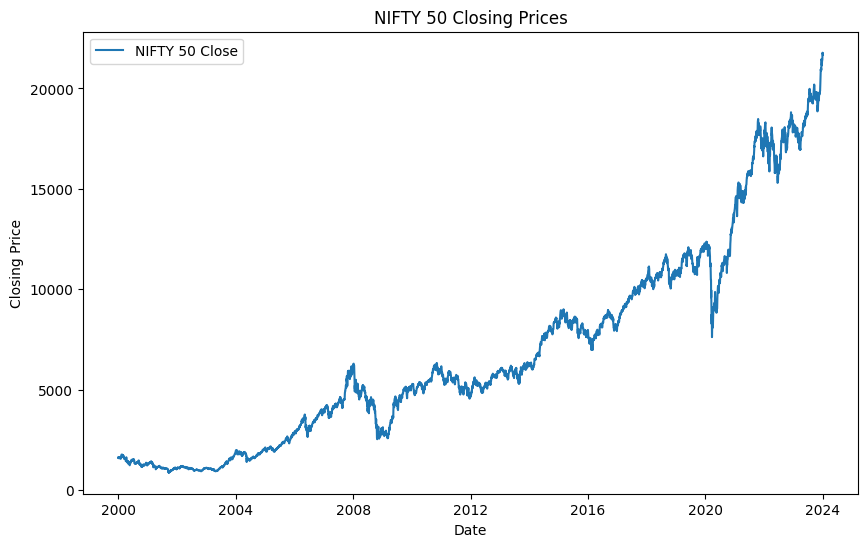

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

nifty_50_df = pd.read_csv('NIFTY50.csv')
nifty_50_df['Date'] = pd.to_datetime(nifty_50_df['Date'])
nifty_50_df.set_index('Date', inplace=True)


plt.figure(figsize=(10, 6))
plt.plot(nifty_50_df['Close'], label='NIFTY 50 Close')
plt.title('NIFTY 50 Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

4675/4675 ━━━━━━━━━━━━━━━━━━━━ 161s 33ms/step - loss: 3.7519e-04
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


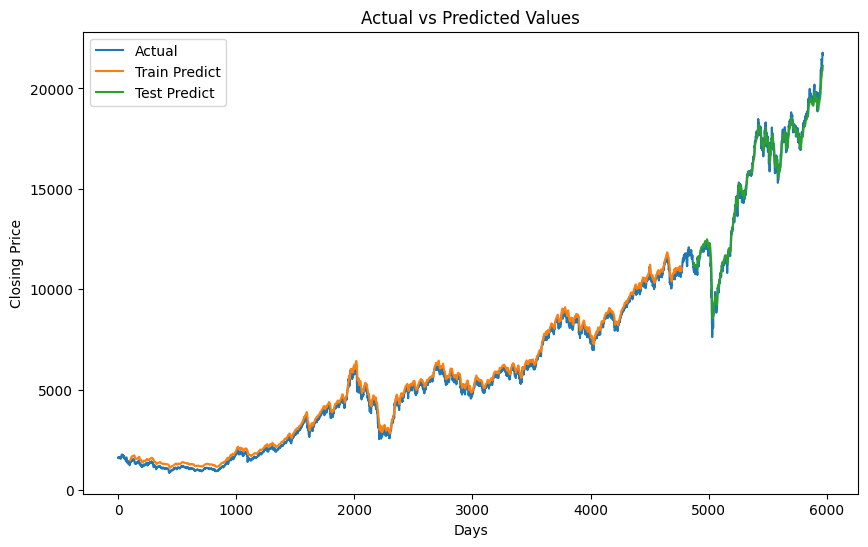

In [ ]:
data = nifty_50_df[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=1)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_y_train = scaler.inverse_transform([y_train])
original_y_test = scaler.inverse_transform([y_test])


train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict


plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual')
plt.plot(train_predict_plot, label='Train Predict')
plt.plot(test_predict_plot, label='Test Predict')
plt.title('Actual vs Predicted Values')
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.legend()
plt.show()